<a href="https://colab.research.google.com/github/Azufendei/Quantum-Computing/blob/main/LAB2QSS2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Utility-Scale Layer Fidelity Experiment

In [ ]:
!pip install qiskit[visualization]==1.1.0
# Use the following if you are on MacOS/zsh
#!pip install 'qiskit[visualization]'==1.1.0
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc
!pip install prototype-zne
!pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=9073cd0ae36dd0d2aca693abb2f7de4b3a52faf4b93da1855da25277e52c03a5
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from qc_grader.challenges.qgss_2024 import *
from math import pi
from qiskit.circuit.library import QFT
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2
generic_backend_v2._NOISE_DEFAULTS["cx"] = (5.99988e-06, 6.99988e-06, 1e-5, 5e-3)

from qiskit import transpile, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.dagcircuit import DAGCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino

# Transpiler Passes
## Layout passes
from qiskit.transpiler.passes.layout.csp_layout import CSPLayout
from qiskit.transpiler.passes.layout.dense_layout import DenseLayout
from qiskit.transpiler.passes.layout.sabre_layout import SabreLayout
from qiskit.transpiler.passes.layout.vf2_layout import VF2Layout
from qiskit.transpiler.passes.layout.trivial_layout import TrivialLayout

## Routing passes
from qiskit.transpiler.passes.routing.basic_swap import BasicSwap
from qiskit.transpiler.passes.routing.lookahead_swap import LookaheadSwap
from qiskit.transpiler.passes.routing.sabre_swap import SabreSwap
from qiskit.transpiler.passes.routing.stochastic_swap import StochasticSwap
from qiskit.transpiler.passes.routing.star_prerouting import StarPreRouting

## Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis.basis_translator import BasisTranslator
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis
### The next pass could also be considered an optimization pass.
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis

## Optimization passes
from qiskit.transpiler.passes.optimization.collect_1q_runs import Collect1qRuns
from qiskit.transpiler.passes.optimization.collect_2q_blocks import Collect2qBlocks
from qiskit.transpiler.passes.optimization.consolidate_blocks import ConsolidateBlocks
from qiskit.transpiler.passes.optimization.commutative_cancellation import CommutativeCancellation

In [ ]:
%set_env QXToken=5cf69d36ae777d8d62f5c06ab7f728fd79a227bcaedd996fb8177ce50c71927716a688b502b9ebe02ec8de78ac9d2ede31e1418d0fa5a98dab9ec3f9e0331aec

env: QXToken=5cf69d36ae777d8d62f5c06ab7f728fd79a227bcaedd996fb8177ce50c71927716a688b502b9ebe02ec8de78ac9d2ede31e1418d0fa5a98dab9ec3f9e0331aec


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token="5cf69d36ae777d8d62f5c06ab7f728fd79a227bcaedd996fb8177ce50c71927716a688b502b9ebe02ec8de78ac9d2ede31e1418d0fa5a98dab9ec3f9e0331aec")

## Choosing a backend

In [ ]:
BACKEND = service.backend("ibm_kyoto")
PATH_ANSWER = list(range(10))


In [ ]:
from qc_grader.challenges.qgss_2024 import grade_lab2_ex1
grade_lab2_ex1(PATH_ANSWER, BACKEND)

Submitting your answer. Please wait...
Nice work, all your answers look correct!


## Part 2: Define Disjoint Layers

In [ ]:
def makePairs(path: list):
  for i in range(len(path)-1):
    yield [path[i], path[i+1]]

def makeLayers(pairs: list[tuple[int,int]]):
  layer_1 = []
  layer_2 = []
  for i,pair in enumerate(pairs):
    if tuple(pair) not in list(BACKEND.coupling_map):
      pair = tuple(reversed(pair))
    if i%2 == 0:
      layer_1.append(pair)
    else:
      layer_2.append(pair)
  return layer_1, layer_2

LAYER_1_ANSWER, LAYER_2_ANSWER = makeLayers(makePairs(PATH_ANSWER))

In [ ]:
from qc_grader.challenges.qgss_2024 import grade_lab2_ex2
grade_lab2_ex2(LAYER_1_ANSWER, LAYER_2_ANSWER, PATH_ANSWER, BACKEND)

Submitting your answer. Please wait...
Nice work, all your answers look correct!


In [ ]:
BACKEND.basis_gates


['ecr', 'id', 'rz', 'sx', 'x']

## Part 3: Construct Clifford Entangling Layers

In [ ]:
from qiskit.quantum_info import Clifford
help(Clifford)

Help on class Clifford in module qiskit.quantum_info.operators.symplectic.clifford:

class Clifford(qiskit.quantum_info.operators.base_operator.BaseOperator, qiskit.quantum_info.operators.mixins.adjoint.AdjointMixin, qiskit.circuit.operation.Operation)
 |  Clifford(data, validate=True, copy=True)
 |  
 |  An N-qubit unitary operator from the Clifford group.
 |  
 |  An N-qubit Clifford operator takes Paulis to Paulis via conjugation
 |  (up to a global phase). More precisely, the Clifford group :math:`\mathcal{C}_N`
 |  is defined as
 |  
 |   .. math::
 |  
 |      \mathcal{C}_N = \{ U \in U(2^N) | U \mathcal{P}_N U^{\dagger} = \mathcal{P}_N \} / U(1)
 |  
 |   where :math:`\mathcal{P}_N` is the Pauli group on :math:`N` qubits
 |   that is generated by single-qubit Pauli operators,
 |   and :math:`U` is a unitary operator in the unitary group
 |   :math:`U(2^N)` representing operations on :math:`N` qubits.
 |   :math:`\mathcal{C}_N` is the quotient group by the subgroup of
 |   scalar

Ordering done to avoid transpilation errors

In [ ]:
from qiskit import QuantumCircuit
CIRC_1_ANSWER = QuantumCircuit(BACKEND.num_qubits)
CIRC_2_ANSWER = QuantumCircuit(BACKEND.num_qubits)
for _circ,layer in [(CIRC_1_ANSWER, LAYER_1_ANSWER),(CIRC_2_ANSWER, LAYER_2_ANSWER)]:
  for qi,qj in layer:
    _circ.ecr(qi,qj)

GATE_NAME = "ecr"

Clifford Circuit 1

In [ ]:
CIRC_1_ANSWER.draw(fold=-1, idle_wires=False)

┌──────┐
q_0: ┤1     ├
     │  Ecr │
q_1: ┤0     ├
     ├──────┤
q_2: ┤1     ├
     │  Ecr │
q_3: ┤0     ├
     ├──────┤
q_4: ┤0     ├
     │  Ecr │
q_5: ┤1     ├
     ├──────┤
q_6: ┤1     ├
     │  Ecr │
q_7: ┤0     ├
     ├──────┤
q_8: ┤0     ├
     │  Ecr │
q_9: ┤1     ├
     └──────┘

Clifford Circuit 2

In [ ]:
CIRC_2_ANSWER.draw(fold=-1, idle_wires=False)

┌──────┐
q_1: ┤0     ├
     │  Ecr │
q_2: ┤1     ├
     ├──────┤
q_3: ┤1     ├
     │  Ecr │
q_4: ┤0     ├
     ├──────┤
q_5: ┤1     ├
     │  Ecr │
q_6: ┤0     ├
     ├──────┤
q_7: ┤1     ├
     │  Ecr │
q_8: ┤0     ├
     └──────┘

In [ ]:
# grade part 3
from qc_grader.challenges.qgss_2024 import grade_lab2_ex3
grade_lab2_ex3(CIRC_1_ANSWER, LAYER_1_ANSWER, GATE_NAME, BACKEND)
grade_lab2_ex3(CIRC_2_ANSWER, LAYER_2_ANSWER, GATE_NAME, BACKEND)

Submitting your answer. Please wait...
Nice work, all your answers look correct!
Submitting your answer. Please wait...
Nice work, all your answers look correct!


## Part 4: Construct EPLG Experiment Circuits

In [ ]:
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def eplg_circuit(num_qubits: int, depth: int, layer: QuantumCircuit, qubits: tuple[int, ...]) -> QuantumCircuit:
    if depth % 2 != 0:
        raise ValueError(f"The depth must be even, got {depth}")

    def parameters():
        _depth = 0
        while True:
            for zi in range(3):
                for q in range(num_qubits):
                    yield Parameter(f"d{_depth}_q{q}_z{zi}")
            _depth += 1
    _parameters = parameters()

    circ = QuantumCircuit(num_qubits)
    def _1q_layer():
        for j in range(3):
            for k in qubits:
                circ.rz(next(_parameters), k)
            if j == 2:
                continue
            circ.sx(qubits)

    for _depth in range(depth // 2):
        circ.barrier(qubits)
        _1q_layer()
        circ.barrier(qubits)
        circ.compose(layer, inplace=True)
    circ.barrier(qubits)
    _1q_layer()
    circ.barrier(qubits)

    # Assuming mirroring is fine
    circ = circ.compose(circ.inverse())

    circ.measure_active()

    pm = generate_preset_pass_manager(basis_gates=["ecr", "sx", "rz"], optimization_level=0)
    circ = pm.run(circ)

    circ.metadata["layer_depth"] = depth
    circ.metadata["qubits"] = qubits
    circ.metadata["num_qubits"] = num_qubits

    return circ


In [ ]:
example_circuit_1 = eplg_circuit(
    num_qubits=BACKEND.num_qubits,
    depth=4,
    layer=CIRC_1_ANSWER,
    qubits=PATH_ANSWER,
)

In [ ]:
example_circuit_1.draw(fold=-1, idle_wires=False)

░ ┌──────────────┐┌────┐┌───────────────┐┌────┐┌───────────────┐ ░ ┌──────┐ ░ ┌───────────────┐┌────┐┌───────────────┐┌────┐┌───────────────┐ ░ ┌──────┐ ░ ┌───────────────┐┌────┐┌───────────────┐┌────┐┌───────────────┐ ░  ░ ┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐ ░ ┌──────┐ ░ ┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐ ░ ┌──────┐ ░ ┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌───────────────────┐ ░  ░ ┌─┐                           
       q_0: ─░─┤ Rz(d0_q0_z0) ├┤ √X ├┤ Rz(d0_q10_z0) ├┤ √X ├┤ Rz(d0_q20_z0) ├─░─┤1     ├─░─┤ Rz(d0_q30_z0) ├┤ √X ├┤ Rz(d0_q40_z0) ├┤ √X ├┤ Rz(d0_q50_z0) ├─░─┤1     ├─░─┤ Rz(d0_q60_z0) ├┤ √X ├┤ Rz(d0_q70_z0) ├┤ √X ├┤ Rz(d0_q80_z0) ├─░──░─┤ Rz(-1.0*d0_q80_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q70_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q60_z0) ├─░─┤1     ├─░─┤ Rz(-1.0*d0_q50_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q40_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q30_z0) ├─░─┤1     ├─░─┤ Rz(-1.0*d0_q20_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q10_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q0_z0) ├─░──░─┤M├───────────────────────────
             ░ ├──────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ │  Ecr │ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ │  Ecr │ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░  ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ │  Ecr │ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ │  Ecr │ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├───────────────────┤ ░  ░ └╥┘┌─┐                        
       q_1: ─░─┤ Rz(d0_q1_z0) ├┤ √X ├┤ Rz(d0_q11_z0) ├┤ √X ├┤ Rz(d0_q21_z0) ├─░─┤0     ├─░─┤ Rz(d0_q31_z0) ├┤ √X ├┤ Rz(d0_q41_z0) ├┤ √X ├┤ Rz(d0_q51_z0) ├─░─┤0     ├─░─┤ Rz(d0_q61_z0) ├┤ √X ├┤ Rz(d0_q71_z0) ├┤ √X ├┤ Rz(d0_q81_z0) ├─░──░─┤ Rz(-1.0*d0_q81_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q71_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q61_z0) ├─░─┤0     ├─░─┤ Rz(-1.0*d0_q51_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q41_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q31_z0) ├─░─┤0     ├─░─┤ Rz(-1.0*d0_q21_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q11_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q1_z0) ├─░──░──╫─┤M├────────────────────────
             ░ ├──────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ ├──────┤ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ ├──────┤ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░  ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ ├──────┤ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ ├──────┤ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├───────────────────┤ ░  ░  ║ └╥┘┌─┐                     
       q_2: ─░─┤ R

In [ ]:
example_circuit_2 = eplg_circuit(
    num_qubits=BACKEND.num_qubits,
    depth=4,
    layer=CIRC_2_ANSWER,
    qubits=PATH_ANSWER,
)

In [ ]:
example_circuit_2.draw(fold=-1, idle_wires=False)

░ ┌──────────────┐┌────┐┌───────────────┐┌────┐┌───────────────┐ ░          ░ ┌───────────────┐┌────┐┌───────────────┐┌────┐┌───────────────┐ ░          ░ ┌───────────────┐┌────┐┌───────────────┐┌────┐┌───────────────┐ ░  ░ ┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐ ░          ░ ┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐ ░          ░ ┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────────────────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌───────────────────┐ ░  ░ ┌─┐                           
       q_0: ─░─┤ Rz(d0_q0_z0) ├┤ √X ├┤ Rz(d0_q10_z0) ├┤ √X ├┤ Rz(d0_q20_z0) ├─░──────────░─┤ Rz(d0_q30_z0) ├┤ √X ├┤ Rz(d0_q40_z0) ├┤ √X ├┤ Rz(d0_q50_z0) ├─░──────────░─┤ Rz(d0_q60_z0) ├┤ √X ├┤ Rz(d0_q70_z0) ├┤ √X ├┤ Rz(d0_q80_z0) ├─░──░─┤ Rz(-1.0*d0_q80_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q70_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q60_z0) ├─░──────────░─┤ Rz(-1.0*d0_q50_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q40_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q30_z0) ├─░──────────░─┤ Rz(-1.0*d0_q20_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q10_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q0_z0) ├─░──░─┤M├───────────────────────────
             ░ ├──────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ ┌──────┐ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ ┌──────┐ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░  ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ ┌──────┐ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ ┌──────┐ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├───────────────────┤ ░  ░ └╥┘┌─┐                        
       q_1: ─░─┤ Rz(d0_q1_z0) ├┤ √X ├┤ Rz(d0_q11_z0) ├┤ √X ├┤ Rz(d0_q21_z0) ├─░─┤0     ├─░─┤ Rz(d0_q31_z0) ├┤ √X ├┤ Rz(d0_q41_z0) ├┤ √X ├┤ Rz(d0_q51_z0) ├─░─┤0     ├─░─┤ Rz(d0_q61_z0) ├┤ √X ├┤ Rz(d0_q71_z0) ├┤ √X ├┤ Rz(d0_q81_z0) ├─░──░─┤ Rz(-1.0*d0_q81_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q71_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q61_z0) ├─░─┤0     ├─░─┤ Rz(-1.0*d0_q51_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q41_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q31_z0) ├─░─┤0     ├─░─┤ Rz(-1.0*d0_q21_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q11_z0) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-1.0*d0_q1_z0) ├─░──░──╫─┤M├────────────────────────
             ░ ├──────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ │  Ecr │ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░ │  Ecr │ ░ ├───────────────┤├────┤├───────────────┤├────┤├───────────────┤ ░  ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ │  Ecr │ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤ ░ │  Ecr │ ░ ├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├────────────────────┤├─────────┤├─────────┤├────┤├─────────┤├─────────┤├───────────────────┤ ░  ░  ║ └╥┘┌─┐                     
       q_2: ─░─┤ R

# Part 5: Construct BindingsArrays

In [ ]:
import numpy as np

from qiskit.primitives.containers.bindings_array import BindingsArray

def get_clifford_rz_samples(
    circ: QuantumCircuit,
    num_samples: int,
    rng: np.random.Generator,
) -> BindingsArray:
    """Uniformly sample the Rz parameters in a `QuantumCircuit`
    from -pi, -pi/2, 0, +pi/2, +pi.
    """

    _allowed_ops = {'rz', 'sx', 'sxdg', 'ecr', 'barrier', 'measure'}
    if (_other := set(circ.count_ops().keys()) - _allowed_ops):
        raise ValueError(f"Circuit must only contain ops: {_allowed_ops}, got {_other}")

    sampled_pars = rng.integers(-2, 3, size=(num_samples, len(circ.parameters))) * (np.pi/2)

    return BindingsArray({
        tuple(circ.parameters): sampled_pars
    })

In [ ]:
num_samples = 10
ARRAY_1_ANSWER = get_clifford_rz_samples(
    circ=example_circuit_1,
    num_samples=num_samples,
    rng=np.random.default_rng(42))

In [ ]:
# grade part 4
from qc_grader.challenges.qgss_2024 import grade_lab2_ex4
grade_lab2_ex4(ARRAY_1_ANSWER, example_circuit_1, num_samples)

Submitting your answer. Please wait...
Nice work, all your answers look correct! 
 Notice that the shape of the BindingsArray is [10], and there are {num_parameters} parameters.



# Part 6: Make ObservablesArrays

In [ ]:
import numpy as np
from itertools import product
from qiskit.quantum_info import SparsePauliOp

def process_fidelity_observable(num_qubits: int, qubits: tuple[int, ...]) -> SparsePauliOp:
    """Produces the all 0 projector on `qubits` tensored with the identity on all other qubits"""
    pauli_strings = []

    for p_sub_str in product(["I", "Z"], repeat=len(qubits)):
        p_str = ["I"] * num_qubits
        for qi, pi in zip(qubits, p_sub_str):
            p_str[qi] = pi
        pauli_strings.append("".join(p_str[::-1]))

    return SparsePauliOp(pauli_strings, np.ones(len(pauli_strings)) / 2**len(qubits))

In [ ]:
from qiskit.primitives.containers.observables_array import ObservablesArray

LAYER_1_SUBSYSTEMS = LAYER_1_ANSWER + [(q,) for q in set(PATH_ANSWER) - set(item for sublist in LAYER_1_ANSWER for item in sublist)]
LAYER_2_SUBSYSTEMS = LAYER_2_ANSWER + [(q,) for q in set(PATH_ANSWER) - set(item for sublist in LAYER_2_ANSWER for item in sublist)]

LAYER_1_OBSERVABLES = ObservablesArray([process_fidelity_observable(BACKEND.num_qubits, qubits) for qubits in LAYER_1_SUBSYSTEMS])
LAYER_2_OBSERVABLES = ObservablesArray([process_fidelity_observable(BACKEND.num_qubits, qubits) for qubits in LAYER_2_SUBSYSTEMS])

In [ ]:
LAYER_1_OBSERVABLES.shape == (len(LAYER_1_SUBSYSTEMS),)
LAYER_2_OBSERVABLES.shape == (len(LAYER_2_SUBSYSTEMS),)

True

## Part 7: Make Sequence of EstimatorPubs

In [ ]:
rng = np.random.default_rng(42)
num_samples = 10
depths = [2, 4, 8, 16, 32, 64]

In [ ]:
from qiskit.primitives.containers.estimator_pub import EstimatorPub

estimator_pubs = []
for depth in depths:
    for layer, name, observables in [(CIRC_1_ANSWER, "circ_1", LAYER_1_OBSERVABLES), (CIRC_2_ANSWER, "circ_2", LAYER_2_OBSERVABLES)]:
        circ = eplg_circuit(
            num_qubits=BACKEND.num_qubits,
            depth=depth,
            layer=layer,
            qubits=PATH_ANSWER,
        )
        circ.metadata["layer_idx"] = name
        bindings_array = get_clifford_rz_samples(
            circ=circ,
            num_samples=num_samples,
            rng=rng,
        )

        # We need to reshape the `ObservablesArray`s and `BindingsArray`s so they
        # can be broadcasted.
        # https://numpy.org/doc/stable/user/basics.broadcasting.html#basics-broadcasting
        estimator_pubs.append(EstimatorPub(
            circuit=circ,
            observables=observables.reshape((*observables.shape, 1)),
            parameter_values=bindings_array.reshape((1, *bindings_array.shape)),
        ))

In [ ]:
num_evs_expected = 0
for pub in estimator_pubs:
    num_evs_expected += np.prod(estimator_pubs[0].shape)
num_evs_expected

600

# Part 8: Submit to Runtime

In [ ]:
from qiskit_ibm_runtime import EstimatorV2
estimator = EstimatorV2(backend=BACKEND)
estimator.options.resilience.measure_mitigation = False

In [ ]:

estimator_job = estimator.run(estimator_pubs)

In [ ]:
primitive_result = estimator_job.result()

primitive_result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(5, 10), dtype=float64>), stds=np.ndarray(<shape=(5, 10), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(5, 10), dtype=float64>), shape=(5, 10)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {'layer_depth': 2, 'qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'num_qubits': 127, 'layer_idx': 'circ_1'}, 'num_randomizations': 32}), PubResult(data=DataBin(evs=np.ndarray(<shape=(6, 10), dtype=float64>), stds=np.ndarray(<shape=(6, 10), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6, 10), dtype=float64>), shape=(6, 10)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {'layer_depth': 2, 'qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'num_qubits': 127, 'layer_idx': 'circ_2'}, 'num_randomizations': 32}), PubResult(data=DataBin(evs=np.ndarray(<shape=(5, 10), dtype=float64>), stds=np.ndarray(<shape=(5, 10), dtype=float64>), ensemble_standard_error=np.ndarray(<shape

# Part 9: Data Analysis

In [ ]:
data_out = {
    "evs": [pub_res.data.evs for pub_res in primitive_result],
    "stds": [pub_res.data.stds for pub_res in primitive_result],
    "result_metadata": primitive_result.metadata,
    "pub_metadata": [pub_res.metadata for pub_res in primitive_result]
}

In [ ]:
# evs_at_depth is a
evs_at_depth = np.zeros((len(depths), data_out['evs'][0].shape[0]*2))
for i in range(len(depths)):
    layer1_evs = np.average(data_out['evs'][2*i], axis=-1)
    layer2_evs = np.average(data_out['evs'][2*i+1], axis=-1)
    evs_at_depth[i,:] = np.array([item for pair in zip(layer1_evs, layer2_evs) for item in pair])

In [ ]:
evs_at_depth.shape

(6, 10)

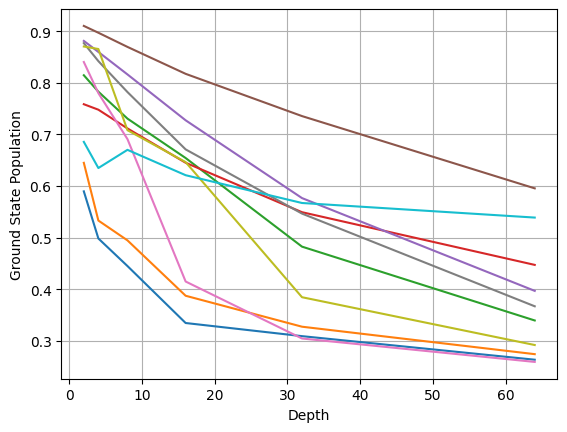

In [ ]:
import matplotlib.pyplot as plt
ax = plt.gca()
for i in range(evs_at_depth.shape[1]):
    ax.plot(depths, evs_at_depth[:,i])

ax.set_ylabel("Ground State Population")
ax.set_xlabel("Depth")
ax.grid()

In [ ]:
!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
import lmfit
model= lmfit.models.ExpressionModel(
            expr="a * alpha ** x + b",
            name="rb_decay")

params_dict = {
    'a': {'value': 1.0,
            'min': -1.0,
            'max': 1.0,
            },
    'b': {'value': 0.0,
            'min': -1.0,
            'max': 1.0,
            },
    'alpha': {'value': 0.9,
              'min': 0.0,
              'max': 1.0
              },
}
p = model.make_params(**params_dict)
alphas = []
for i in range(evs_at_depth.shape[-1]):
    result = model.fit(evs_at_depth[:,i], p, x=depths)
    alphas.append(result.params['alpha'].value)

In [ ]:
def cal_process_fid(alpha, D=4):
    epsilon = (D-1) * (1 - alpha)/D
    Fg = 1 - epsilon
    Fp = ((D+1) * Fg -1)/D
    return Fp

In [ ]:
import pandas as pd

qubit_pairs = [item for pair in zip(LAYER_1_ANSWER, LAYER_2_ANSWER) for item in pair]
pfs = [cal_process_fid(alpha) for alpha in alphas]
df = pd.DataFrame(zip(qubit_pairs, alphas, pfs), columns=['qubit pair', 'alpha', 'process fidelity'])
df

,qubit pair,alpha,process fidelity
0,"(1, 0)",0.896313,0.902793
1,"[1, 2]",0.919203,0.924252
2,"(3, 2)",0.975843,0.977353
3,"(4, 3)",0.900000,0.906250
4,"[4, 5]",0.982311,0.983416
5,"(6, 5)",0.989800,0.990437
6,"(7, 6)",0.927245,0.931792
7,"(8, 7)",0.974948,0.976513


In [ ]:
# Compute layer fidelity
chain_lens = np.arange(2, len(pfs), 1)
chain_fids = []
for length in chain_lens:
     w = length + 1  # window size
     fid_w = max(
          np.sqrt(pfs[s]) * np.prod(pfs[s + 1 : s + w - 1]) * np.sqrt(pfs[s + w - 1]) for s in range(len(pfs) - w + 1))
     chain_fids.append(fid_w)

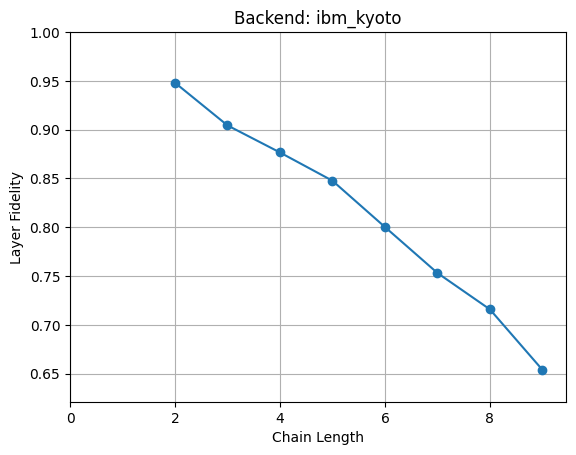

In [ ]:
# Plot LF by chain length
plt.title(f"Backend: {BACKEND.name}")
plt.plot(
    chain_lens,
    chain_fids,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1] * 1.05)
plt.ylim(0.95 * min(chain_fids), 1)
plt.ylabel("Layer Fidelity")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

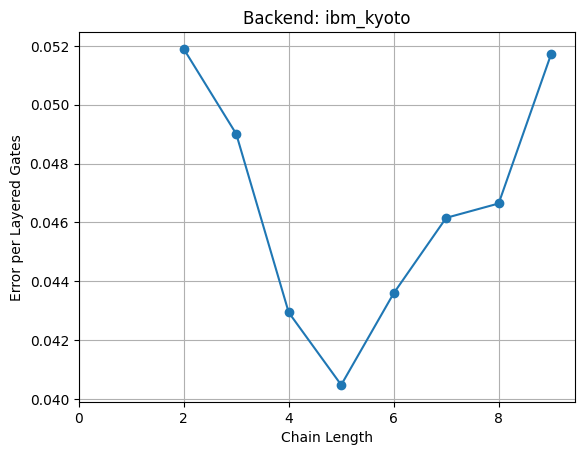

In [ ]:
# Plot EPLG by chain length
num_2q_gates = [length - 1 for length in chain_lens]
chain_eplgs = [
    1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, chain_fids)
]
plt.title(f"Backend: {BACKEND.name}")
plt.plot(
    chain_lens,
    chain_eplgs,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1] * 1.05)
plt.ylabel("Error per Layered Gates")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

In [ ]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))